# **EDA**

The below analyzes the delay data for airlines as is supplied by the Bureau of Transportation Statistics (BoTS). The below links can direct you to the data:
- [Overview of Delay Data](https://www.transtats.bts.gov/TableInfo.asp?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr&V0s1_b0yB=D)
- [Download Link for Delay Data](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr)
- [Data Dictionary](https://www.transtats.bts.gov/printglossary.asp)

In [1]:
# Change CWD to repo base for imports
import os
from pathlib import Path
notebook_path = Path().resolve()
parent_directory = notebook_path.parent
os.chdir(parent_directory)

# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from etl import get_flight_data

In [2]:
df = get_flight_data()

reading data/202312_flights.csv
reading data/202307_flights.csv
reading data/202402_flights.csv
reading data/202308_flights.csv
reading data/202404_flights.csv
skipped data/state_region_map.csv
reading data/202401_flights.csv
reading data/202311_flights.csv
reading data/202406_flights.csv
reading data/202403_flights.csv
skipped data/airport_id_map.csv
reading data/202310_flights.csv
skipped data/airline_codes_map.csv
reading data/202405_flights.csv
reading data/202309_flights.csv


# **Features Background**
### **Seasonality in flight volumes?**

<Axes: title={'center': 'Average Flights per Hour'}, xlabel='hour_of_day'>

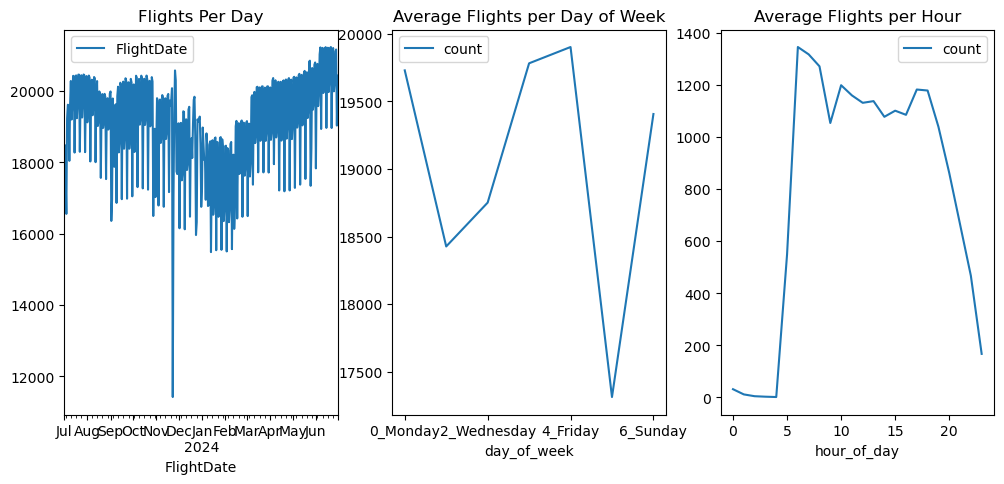

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

# flights per day
df.groupby(by=pd.Grouper(key='FlightDate', freq='D')).agg({'FlightDate': 'count'}).plot(ax=ax[0], title='Flights Per Day')

# avg flights per day of week
daily_dow_counts = df.groupby(
    by=[pd.Grouper(key="FlightDate", freq="D"), "day_of_week"]
).agg({'FlightDate': 'count'}).rename(columns={'FlightDate': 'count'})
average_dow_counts = daily_dow_counts.groupby("day_of_week").mean()
average_dow_counts.plot(ax=ax[1], title='Average Flights per Day of Week')

# avg flights per hours
daily_hourly_counts = df.groupby(
    by=[pd.Grouper(key="FlightDate", freq="D"), "hour_of_day"]
).agg({'FlightDate': 'count'}).rename(columns={'FlightDate': 'count'})
average_hourly_counts = daily_hourly_counts.groupby("hour_of_day").mean()
average_hourly_counts.plot(ax=ax[2], title='Average Flights per Hour')

### **Flight Destinations?**

<Axes: title={'center': 'Top 15 Destination Airports'}, xlabel='DestAirportName'>

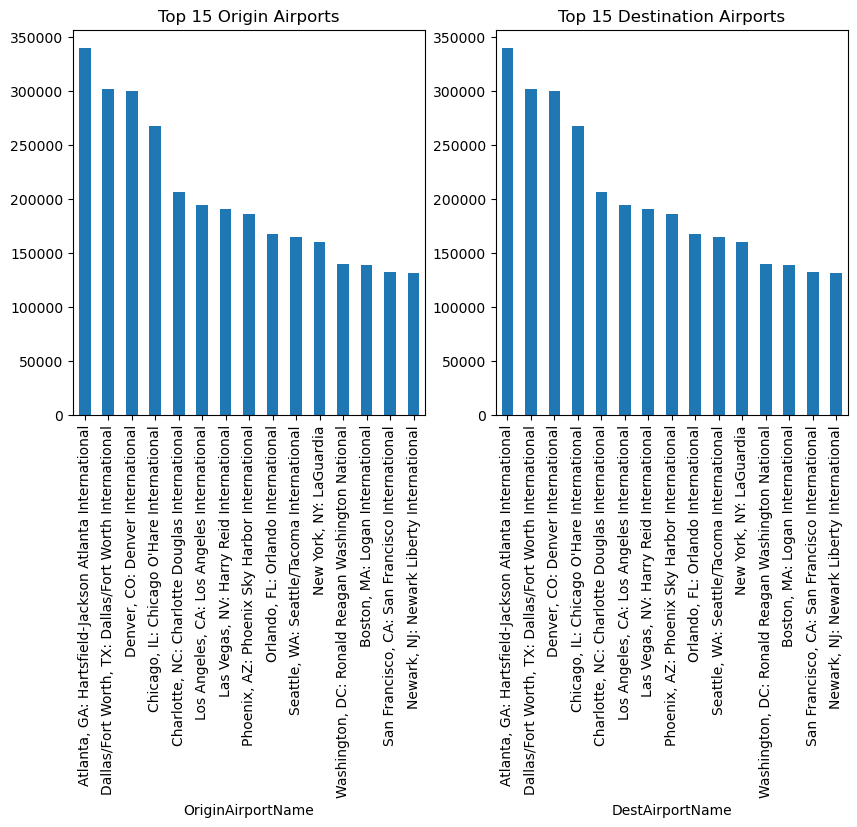

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df.groupby(by="OriginAirportName")["FlightDate"].count().sort_values(ascending=False).head(15).plot(kind="bar", ax=ax[0], title="Top 15 Origin Airports")
df.groupby(by="DestAirportName")["FlightDate"].count().sort_values(ascending=False).head(15).plot(kind="bar", ax=ax[1], title="Top 15 Destination Airports")

<Axes: title={'center': 'Top 15 Destination States'}, xlabel='DestAirportState'>

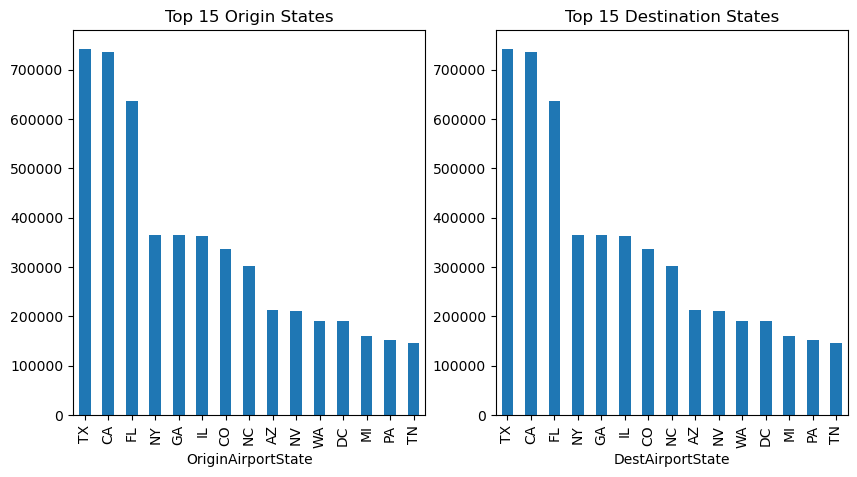

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df.groupby(by="OriginAirportState")["FlightDate"].count().sort_values(ascending=False).head(15).plot(kind="bar", ax=ax[0], title="Top 15 Origin States")
df.groupby(by="DestAirportState")["FlightDate"].count().sort_values(ascending=False).head(15).plot(kind="bar", ax=ax[1], title="Top 15 Destination States")

<Axes: title={'center': 'Top 15 Destination States'}, xlabel='DestDivision'>

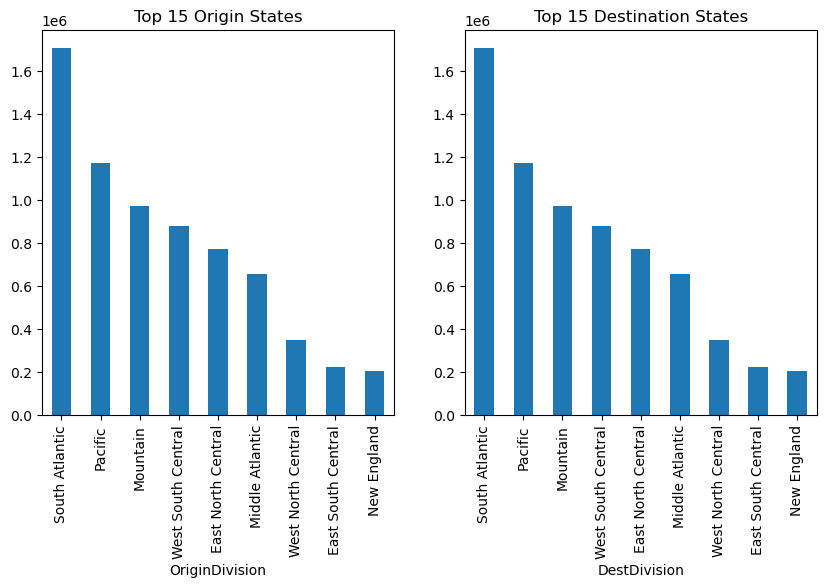

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df.groupby(by="OriginDivision")["FlightDate"].count().sort_values(ascending=False).head(15).plot(kind="bar", ax=ax[0], title="Top 15 Origin States")
df.groupby(by="DestDivision")["FlightDate"].count().sort_values(ascending=False).head(15).plot(kind="bar", ax=ax[1], title="Top 15 Destination States")

### **What are the airlines in the data?**

<Axes: title={'center': 'Top Airlines'}, xlabel='Airline_Name'>

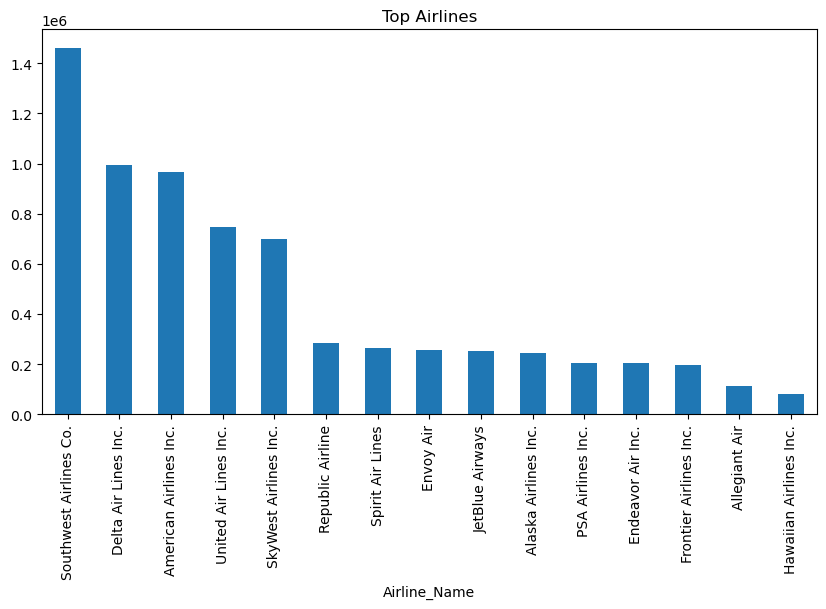

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

df.groupby(by="Airline_Name")["FlightDate"].count().sort_values(ascending=False).head(15).plot(kind="bar", ax=ax, title="Top Airlines")

### **How long are the flights?**

Text(0.5, 1.0, 'ActualElapsedTime (Minutes)')

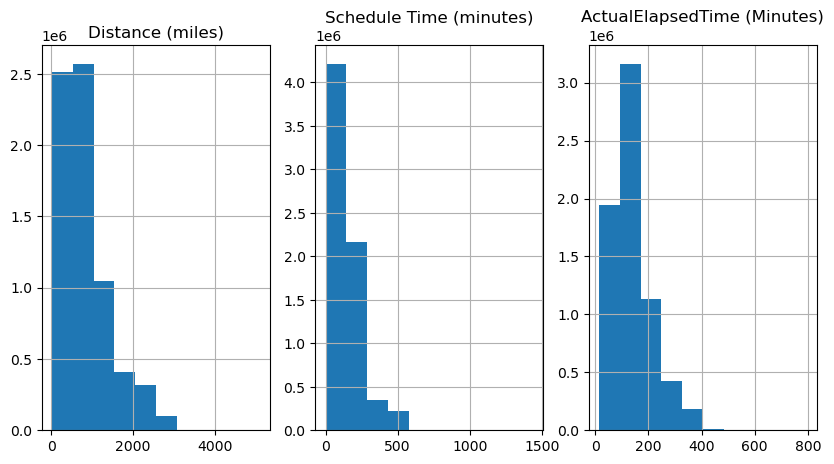

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

df.Distance.hist(ax=ax[0])
ax[0].set_title("Distance (miles)")

df.ScheduledDurationMinutes.hist(ax=ax[1])
ax[1].set_title("Schedule Time (minutes)")

df.ActualElapsedTime.hist(ax=ax[2])
ax[2].set_title("ActualElapsedTime (Minutes)")

# **Targets (Cancellation/Delays) Background**
### **Frequency / Distribution of Delays**

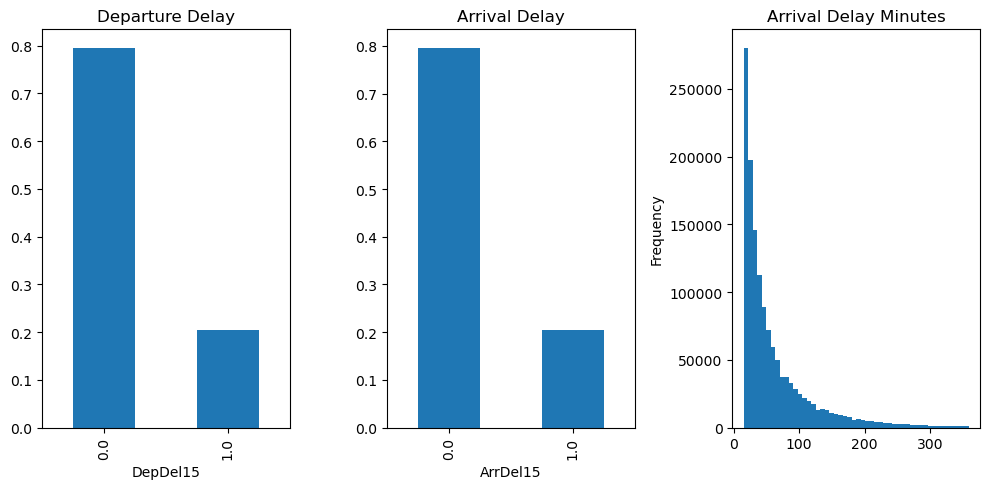

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

df.DepDel15.value_counts(normalize=True).plot(kind="bar", title="Departure Delay", ax=ax[0])
df.ArrDel15.value_counts(normalize=True).plot(kind="bar", title="Arrival Delay", ax=ax[1])
df.loc[(df.ArrDel15 == 1.0) & (df.ArrDelayMinutes < 60*6
                            )].ArrDelayMinutes.plot(kind="hist", bins=50, title="Arrival Delay Minutes", ax=ax[2])

plt.tight_layout()

### **Frequency of Cancellations**

In [10]:
df.Cancelled.value_counts(normalize=True)

Cancelled
0.0    0.987835
1.0    0.012165
Name: proportion, dtype: float64

# **Target Pairwise EDA**
### **Cancellation/Delay by Airline**

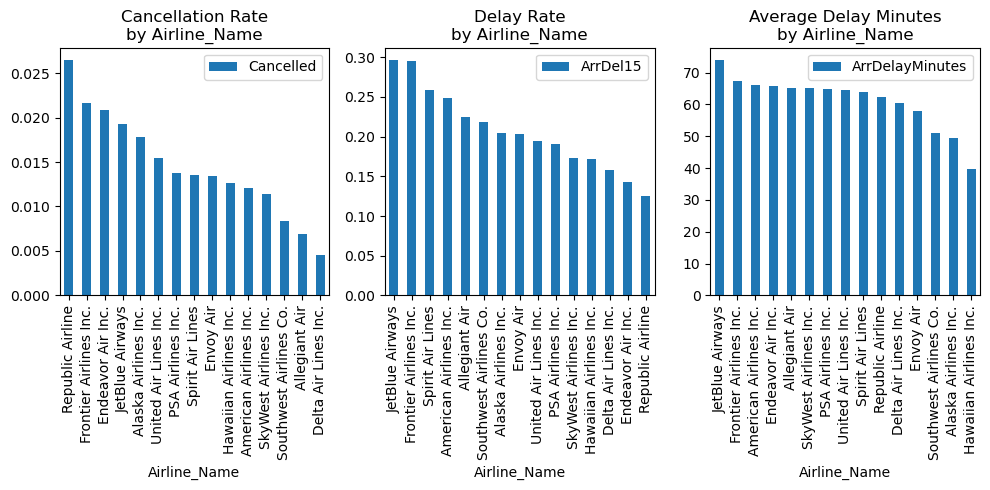

In [11]:
def plot_targets(group_col, plot_top_n=15):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    
    plot_col = f"{group_col}_top" if plot_top_n else group_col
    if plot_top_n:
        # Identify the top 15 values by count
        top_values = df[group_col].value_counts().nlargest(plot_top_n).index
        # Replace values not in the top 15 with 'others'
        df[f"{group_col}_top"] = np.where(df[group_col].isin(top_values), df[group_col], "others")

    df.groupby(by=[plot_col]).agg({"Cancelled": "mean"}).sort_values(by="Cancelled", ascending=False).plot(kind="bar", ax=ax[0], title=f"Cancellation Rate\nby {group_col}")
    df.groupby(by=[plot_col]).agg({"ArrDel15": "mean"}).sort_values(by="ArrDel15", ascending=False).plot(kind="bar", ax=ax[1], title=f"Delay Rate\nby {group_col}")
    delay_mask = (df.ArrDel15 == 1.0) & (df.ArrDelayMinutes < 60*6)
    df.loc[delay_mask].groupby(by=[plot_col]).agg({"ArrDelayMinutes": "mean"}).sort_values(by="ArrDelayMinutes", ascending=False).plot(kind="bar", ax=ax[2], title=f"Average Delay Minutes\nby {group_col}")
    plt.tight_layout()

    if plot_top_n:
        df.drop(columns=[f"{group_col}_top"], inplace=True)
    return fig, ax

fig, ax = plot_targets("Airline_Name", plot_top_n=None)

### **Cancellation/Delay by Airport**

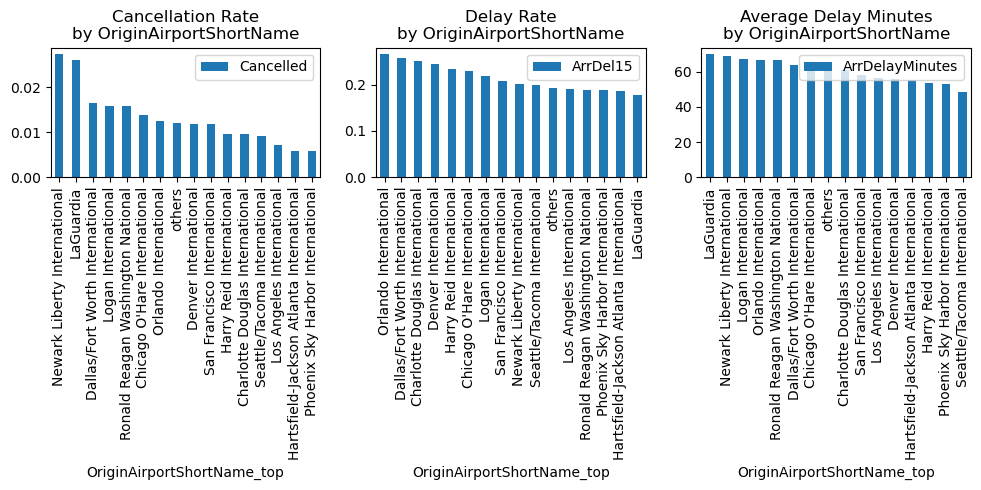

In [12]:
fig, ax = plot_targets("OriginAirportShortName")

### **Cancellation/Delay by Region**

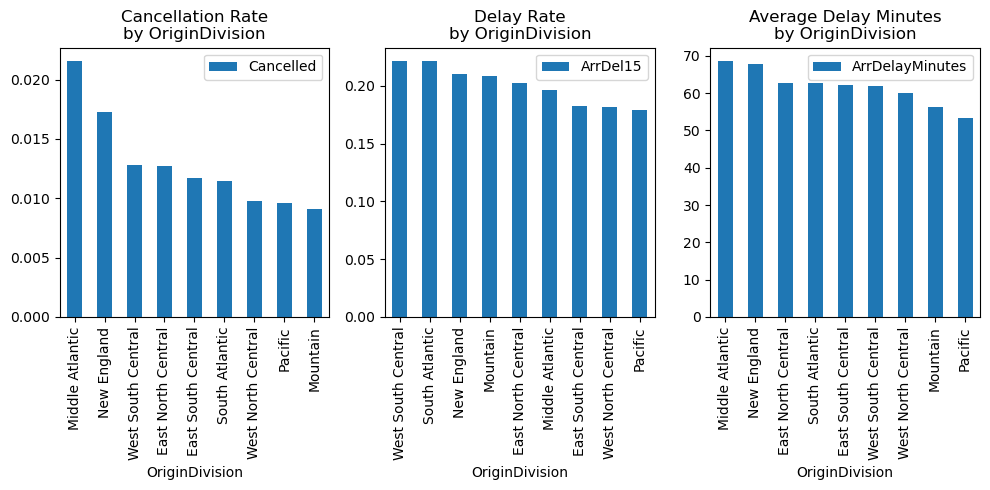

In [13]:
fig, ax = plot_targets("OriginDivision", plot_top_n=None)

### **Cancellation/Delay by Day of Week**

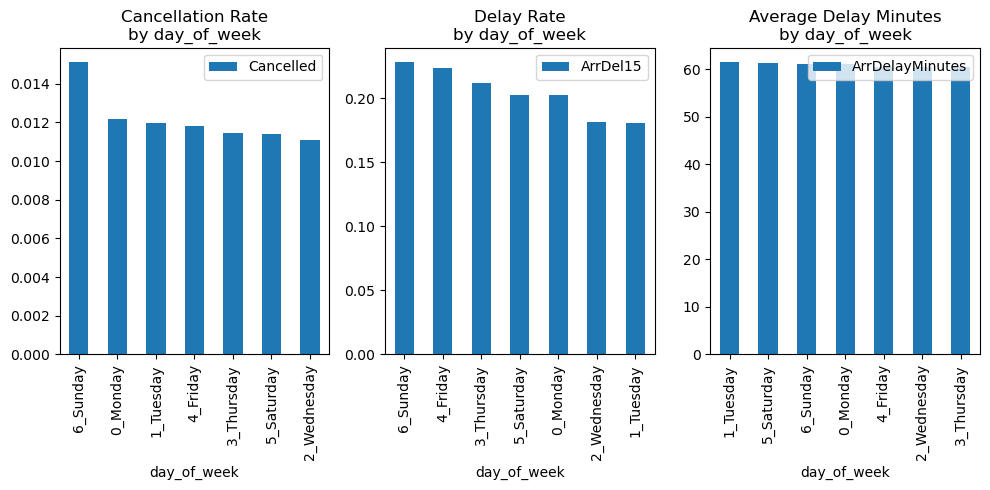

In [14]:
fig, ax = plot_targets("day_of_week", plot_top_n=None)

### **Cancellation/Delay Time of Day**

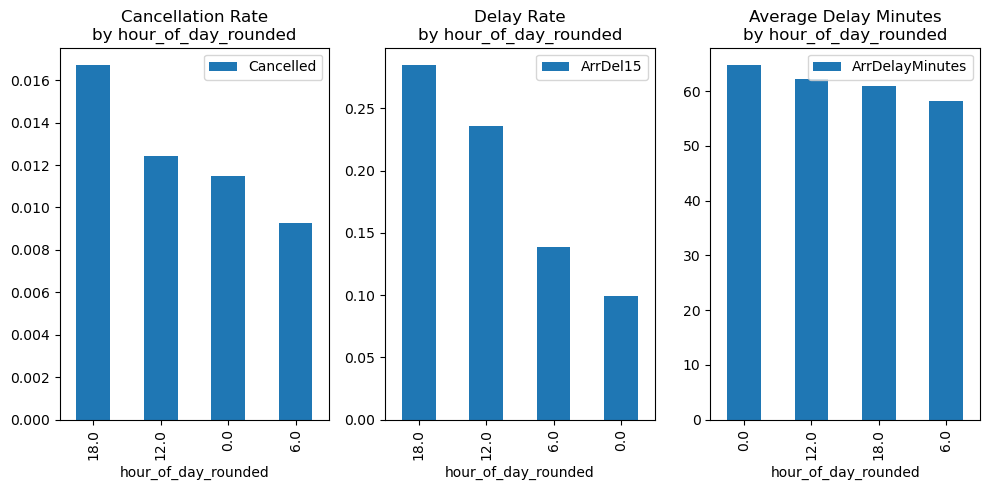

In [15]:
df["hour_of_day_rounded"] = df.hour_of_day // 6 * 6
fig, ax = plot_targets("hour_of_day_rounded", plot_top_n=None)

### **Cancellation/Delay by Time of Year**

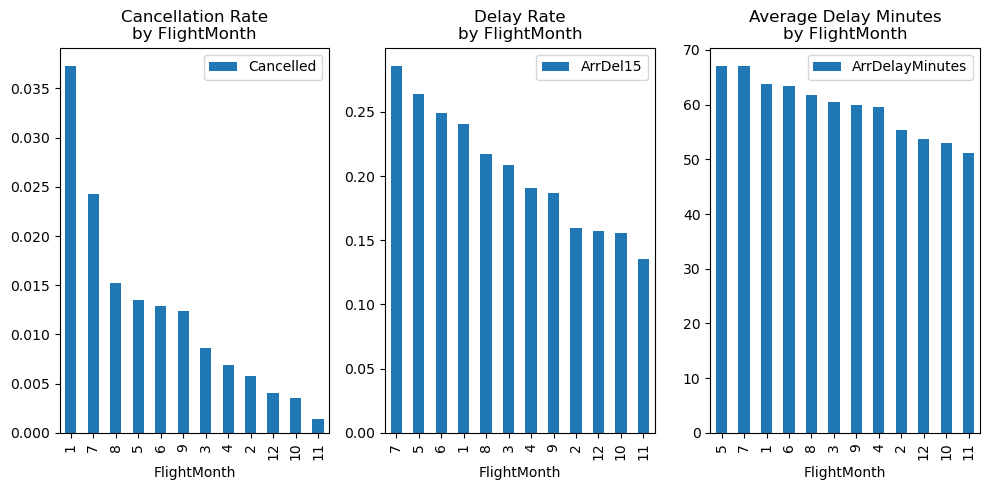

In [16]:
df["FlightMonth"] = (df["FlightDate"].dt.month)
fig, ax = plot_targets("FlightMonth", plot_top_n=None)

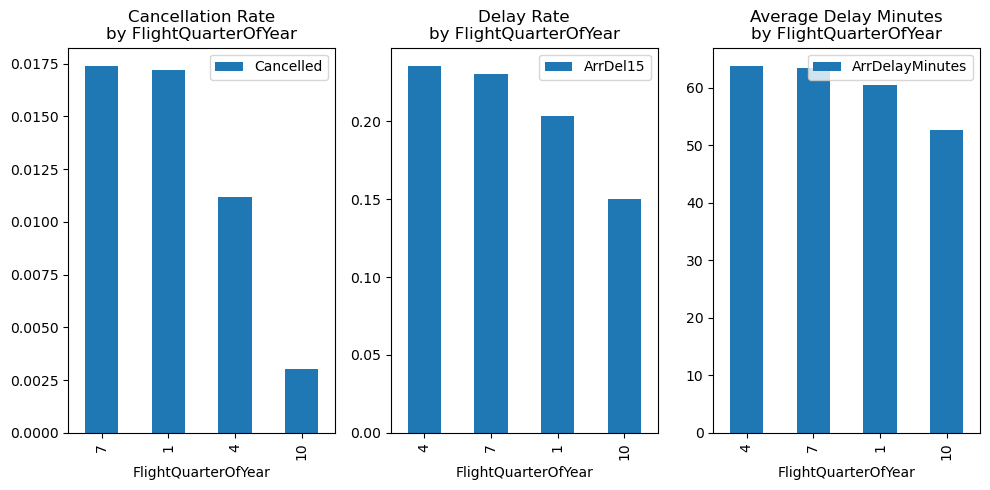

In [17]:
df["FlightQuarterOfYear"] = (df["FlightDate"].dt.month - 1) // 3 * 3 + 1
fig, ax = plot_targets("FlightQuarterOfYear", plot_top_n=None)